Portfolio Check
=====================

An interactive OpenQuake (OQ) tool to build a portfolio of assets and check their risk. Written by Tiegan Hobbs ([tieganh](https://github.com/tieganh)) on 11 May 2020 for python. This document is intended for demonstration purposes, and licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by-sa/4.0/). 
![alt text](https://i.creativecommons.org/l/by-sa/4.0/80x15.png "CC BY-SA 4.0")

------------

## Table of Contents 

0. [System Requirements](#System-Requirements)
1. [Build Portfolio](#Build-Portfolio)
2. [Run Scenario](#Run-Scenario)
3. [View Report](#View-Report)


----------
---------

# System Requirements
To run this tutorial you will need to have OQ installed. Test it by running the code below to ensure you get a recent version (ex: '3.9.0-gitdcd091b') rather than an error. Assuming it works, run `oq webui start` in a terminal window to initialize the OQ web interface. If you encounter errors, see the [installation guide](https://github.com/gem/oq-engine/blob/master/doc/installing/development.md).

In [1]:
%%bash
oq --version

here:  /Users/thobbs/openquake/src/oq-engine/openquake/hazardlib/gsim/NBCC2020_tables/BC17/BC17_2k_V2.hdf5
3.9.0-gitdcd091b


-----------
------------

# Building Portfolio

Drag the marker to your asset of concern, then click 'Point Selected'.

In [59]:
from ipyleaflet import Map, Marker
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import glob
import os

center = (49.2609, -123.0924)
m = Map(center=center, zoom=15)
marker = Marker(location=center, draggable=True)
m.add_layer(marker);

display(m)

button = widgets.Button(
    description='Point Selected',
)
@button.on_click
def plot_on_click(b):
    global LAT, LON
    LAT, LON = marker.location
    print("Current latitude longitude are: ",'%.4f'%LAT,'%.4f'%LON)
button

Map(center=[49.2609, -123.0924], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

Button(description='Point Selected', style=ButtonStyle())

Current latitude longitude are:  49.2609 -123.0924


----------
Select your construction type from the dropdowns below. When finished, click 'Calculate Building'.

In [100]:
#Creating a dataframe with the possible options
df = pd.DataFrame([['Light [<5000 sq ft]','Commercial/Industrial [>5000 sq ft]'],
             ['Steel Moment Frame','Steel Braced Frame','Steel Light Frame','Steel Frame with Cast-in-Place Concrete Shear Walls','Steel Frame with Unreinforced Masonry Infill Walls'],
             ['Concrete Moment Frame','Concrete Shear Walls','Concrete with URM Infill'],
             ['Precast Concrete Tilt-Up Walls','Precast Concrete Frames with Concrete Shear Walls'],
             ['Reinforced Masonry with Wood/Metal Diaphragm','Reinforced Masonry with Precast Concrete Diaphragm'],
             ['-'],
             ['-']], index = ['Wood','Steel','Concrete','Precast','Reinforced Masonry','Unreinforced Masonry','Mobile Home']).transpose()

#Define my widgets for this section
bldgA_widget = widgets.Dropdown(options = ['Wood','Steel','Concrete','Precast','Reinforced Masonry','Unreinforced Masonry','Mobile Home'], value='Wood')
bldgB_widget = widgets.Dropdown(options = ['Light [<5000 sq ft]','Commercial/Industrial [>5000 sq ft]'])
Stor_widget = widgets.Dropdown(options = ['1-3 Storeys','4-7 Storeys','8+ Storeys'], value='1-3 Storeys')
year_widget = widgets.Dropdown(options = ['Pre-1973','1973-1990','1990-2005','2005-present'], value='2005-present', description='Constructed?')

# Define a function that updates the content of y based on what we select for x
def update(*args):
    bldgB_widget.options = df[bldgA_widget.value].dropna().unique().tolist()
bldgA_widget.observe(update)

# Call the widgets to specify building type
@widgets.interact
def random_function():
    display(Stor_widget)
    display(bldgA_widget)
    display(bldgB_widget)
    display(year_widget)

# Calculate the building typology based on widget values
def calc_building(bu):
    global CONSTRUCTION, RISE, YRGROUP
    if Stor_widget.value == '1-3 Storeys':
        RISE = 'L'
    elif Stor_widget.value == '4-7 Storeys':
        RISE = 'M'
    else:
        RISE = 'H'
    YRGROUP = year_widget.value
    if bldgA_widget.value == 'Mobile Homes':
        CONSTRUCTION = 'MH'
    elif bldgA_widget.value == 'Wood':
        if bldgB_widget.value == 'Light [<5000 sq ft]':
            CONSTRUCTION = 'W1'
        else:
            CONSTRUCTION = 'W2'
    else:
        if bldgA_widget.value == 'Unreinforced Masonry':
            if RISE == 'L':
                CONSTRUCTION = 'URML'
            else:
                CONSTRUCTION = 'URMM'
        elif bldgB_widget.value == 'Steel Moment Frame':
            CONSTRUCTION = 'S1'+str(RISE)
        elif bldgB_widget.value == 'Steel Braced Frame':
            CONSTRUCTION = 'S2'+str(RISE)
        elif bldgB_widget.value == 'Steel Light Frame':
            CONSTRUCTION = 'S3'+str(RISE)
        elif bldgB_widget.value == 'Steel Frame with Cast-in-Place Concrete Shear Walls':
            CONSTRUCTION = 'S4'+str(RISE)
        elif bldgB_widget.value == 'Steel Frame with Unreinforced Masonry Infill Walls':
            CONSTRUCTION = 'S5'+str(RISE)
        elif bldgB_widget.value == 'Concrete Moment Frame':
            CONSTRUCTION = 'C1'+str(RISE)
        elif bldgB_widget.value == 'Concrete Shear Walls':
            CONSTRUCTION = 'C2'+str(RISE)
        elif bldgB_widget.value == 'Concrete with URM Infill':
            CONSTRUCTION = 'C3'+str(RISE)
        elif bldgB_widget.value == 'Precast Concrete Tilt-Up Walls':
            CONSTRUCTION = 'PC1'
        elif bldgB_widget.value == 'Precast Concrete Frames with Concrete Shear Walls':
            CONSTRUCTION = 'PC2'+str(RISE)
        elif bldgB_widget.value == 'Reinforced Masonry with Wood/Metal Diaphragm':
            CONSTRUCTION = 'RM1'+str(RISE)
        elif bldgB_widget.value == 'Reinforced Masonry with Precast Concrete Diaphragm':
            CONSTRUCTION = 'RM2'+str(RISE)
        else:
            CONSTRUCTION = 'NOPE'
    print(CONSTRUCTION)

# Call the button
buttonCons = widgets.Button(description="Calculate Building")
buttonCons.on_click(calc_building)
display(buttonCons)


interactive(children=(Output(),), _dom_classes=('widget-interact',))

Button(description='Calculate Building', style=ButtonStyle())

**NOTE: Waiting on data to assign building code correctly. Currently assigning all buildings to Zone 2 (no high code).**

----------

Select your occupancy class and number of occupants below. When finished, click 'Calculate Occupancy'.

In [4]:
#Creating a dataframe with the possible options
dfo = pd.DataFrame([['Single Family','Mobile Home','Multi Family','Temporary Lodging','Institutional Dormitory','Nursing Home'],
             ['Retail Trade','Wholesale Trade','Personal & Repair Services','Professional/Technical Services','Banks','Hospital','Medical Office/Clinic','Entertainment & Recreation','Theaters','Parking'],
             ['Heavy','Light','Food/Drugs/Chemicals','Metal/Minerals Processing','High Technology','Construction'],
             ['Agriculture'],
             ['Church/Non Profit'],
             ['General Services','Emergency Response'],
             ['Grade Schools','Colleges/Universities']], index = ['Residential','Commercial','Industrial','Agriculture','Religion/Non Profit','Government','Education']).transpose()

#Define my widgets for this section

occA_widget = widgets.Dropdown(options = ['Residential','Commercial','Industrial','Agriculture','Religion/Non Profit','Government','Education'], value='Residential')
occB_widget = widgets.Dropdown(options = ['Single Family','Mobile Home','Multi Family','Temporary Lodging','Institutional Dormitory','Nursing Home'])
optional_widget = widgets.Dropdown(options = ['Duplex','3-4 Units','5-9 Units','10-19 Units','20-49 Units','50+ Units'], value='Duplex')
nightin = widgets.BoundedIntText(description="Night", min=0, max=1000)
dayin = widgets.BoundedIntText(description="Day", min=0, max=1000)
transin = widgets.BoundedIntText(description="Transit", min=0, max=1000)

# Define a function that updates the content of y based on what we select for x
def update(*args):
    occB_widget.options = dfo[occA_widget.value].dropna().unique().tolist()
occA_widget.observe(update)

def updateagain(*args):
    if occB_widget.value == 'Multi Family':
        display(optional_widget)
occB_widget.observe(updateagain, names=['value'])

# Call the widgets to specify building type
@widgets.interact
def random_function():
    display(occA_widget)
    display(occB_widget)
    print("Occupants:")
    display(nightin)
    display(dayin)
    display(transin)

def calc_occ(wut):
    global OCC, DAY, NIGHT, TRANSIT
    if occB_widget.value == 'Single Family':
        OCC = 'RES1'
    elif occB_widget.value == 'Mobile Home':
        OCC = 'RES2'
    elif occB_widget.value == 'Multi Family':
        if optional_widget.value == 'Duplex':
            OCC = 'RES3A'
        elif optional_widget.value == '3-4 Units':
            OCC = 'RES3B'
        elif optional_widget.value == '5-9 Units':
            OCC = 'RES3C'
        elif optional_widget.value == '10-19 Units':
            OCC = 'RES3D'
        elif optional_widget.value == '20-49 Units':
            OCC = 'RES3E'
        elif optional_widget.value == '50+ Units':
            OCC = 'RES3F'
    elif occB_widget.value == 'Temporary Lodging':
        OCC = 'RES4'
    elif occB_widget.value == 'Institutional Dormitory':
        OCC = 'RES5'
    elif occB_widget.value == 'Nursing Home':
        OCC = 'RES6'
    elif occB_widget.value == 'Retail Trade':
        OCC = 'COM1'
    elif occB_widget.value == 'Wholesale Trade':
        OCC = 'COM2'
    elif occB_widget.value == 'Personal & Repair Services':
        OCC = 'COM3'
    elif occB_widget.value == 'Professional/Technical Services':
        OCC = 'COM4'
    elif occB_widget.value == 'Banks':
        OCC = 'COM5'
    elif occB_widget.value == 'Hospital':
        OCC = 'COM6'
    elif occB_widget.value == 'Medical Office/Clinic':
        OCC = 'COM7'
    elif occB_widget.value == 'Entertainment & Recreation':
        OCC = 'COM8'
    elif occB_widget.value == 'Theaters':
        OCC = 'COM9'
    elif occB_widget.value == 'Parking':
        OCC = 'COM10'
    elif occB_widget.value == 'Heavy':
        OCC = 'IND1'
    elif occB_widget.value == 'Light':
        OCC = 'IND2'
    elif occB_widget.value == 'Food/Drugs/Chemicals':
        OCC = 'IND3'
    elif occB_widget.value == 'Metal/Minerals Processing':
        OCC = 'IND4'
    elif occB_widget.value == 'High Technology':
        OCC = 'IND5'
    elif occB_widget.value == 'Construction':
        OCC = 'IND6'
    else:
        OCC = 'NOPE'
    NIGHT=nightin.value
    DAY=dayin.value
    TRANSIT=transin.value
    print(OCC, DAY, NIGHT, TRANSIT)
        
buttonOcc = widgets.Button(description = "Calculate Occupancy")
buttonOcc.on_click(calc_occ)
display(buttonOcc)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

Button(description='Calculate Occupancy', style=ButtonStyle())

RES1 0 2 1
RES1 0 4 2


--------

Use the button below to add this building to your Portfolio. 

You can add more buildings by changing above parameters and clicking this button to add them. 

In [6]:
# Build dataframe from code-year chart
codetable = pd.DataFrame([['PC','PC','PC','PC','PC'],
                         ['MC','MC','LC','PC','PC'],
                         ['HC','MC','MC','LC','PC'],
                         ['HC','HC','MC','LC','LC']], index=['Pre-1973','1973-1990','1990-2005','2005-present']).transpose()

# Initialize CSV file
CSV_OUTPUT="./exposure.csv"
ID=1; NUM="1"
with open(CSV_OUTPUT, 'w', newline='') as outcsv:
    writer = csv.writer(outcsv)
    writer.writerow(["id","lon","lat","taxonomy","number","day","night","transit"])
    
# Define function to add line to csv
def append_list_as_row(file_name, list_of_elem):
    # Open file in append mode
    with open(file_name, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        csv_writer = csv.writer(write_obj)
        # Add contents of list as last row in the csv file
        csv_writer.writerow(list_of_elem)

# Define button to add the line to csv file
buttonAdd = widgets.Button(description = "Add Building")

def evaluate(buttonAdd):
    global ID
    if RISE == 'L':
        SA = 1.4998 #fetch SA(0.2)
    
        if SA >= 1.500:
            CODE = codetable[YRGROUP].iloc[0]
        elif 1.000 <= SA < 1.500:
            CODE = codetable[YRGROUP].iloc[1]
        elif 0.500 <= SA < 1.000:
            CODE = codetable[YRGROUP].iloc[2]
        elif 0.250 <= SA < 0.500:
            CODE = codetable[YRGROUP].iloc[3]
        elif SA < 0.250:
            CODE = codetable[YRGROUP].iloc[4]
    else:
        SA = 0.41 #fetch SA(1.0)
        if SA >= 0.600:
            CODE = codetable[YRGROUP].iloc[0]
        elif 0.400 <= SA < 0.600:
            CODE = codetable[YRGROUP].iloc[1]
        elif 0.200 <= SA < 0.400:
            CODE = codetable[YRGROUP].iloc[2]
        elif 0.100 <= SA < 0.200:
            CODE = codetable[YRGROUP].iloc[3]
        elif SA < 0.100:
            CODE = codetable[YRGROUP].iloc[4]

    if (CODE == 'PC') & (CONSTRUCTION == 'W1') & (YRGROUP != 'Pre-1973'):
        CODE = 'LC'

    TAXO = str(OCC)+"-"+str(CONSTRUCTION)+"-"+str(CODE)
    print("id,lon,lat,taxonomy,number,day,night,transit")
    newline = [str(ID),str(LON),str(LAT),str(TAXO),str(NUM),str(DAY),str(NIGHT),str(TRANSIT)]
    print(ID,'%.4f'%LON,'%.4f'%LAT,TAXO,NUM,DAY,NIGHT,TRANSIT,sep=",")
    
    ID = ID + 1
    
    #Add to CSV
    append_list_as_row(CSV_OUTPUT, newline)



buttonAdd.on_click(evaluate)
display(buttonAdd)






Button(description='Add Building', style=ButtonStyle())

id,lon,lat,taxonomy,number,day,night,transit
1,-123.0924,49.2609,RES1-W1-HC,1,0,2,1
id,lon,lat,taxonomy,number,day,night,transit
2,-123.0924,49.2609,RES1-W1-HC,1,0,4,2


-----------
---------

# Run Calculation

**NOTE: Currently treating soil as stiff, reasonable for Vancouver. In future will be able to query database to get location-specific result.**

In [26]:
%%bash

#Build the rest of the files
XML_OUTPUT="./exposure.xml"

cat > exposure.xml << EOF
<?xml version="1.0" encoding="UTF-8"?>
<nrml xmlns="http://openquake.org/xmlns/nrml/0.4">
    <exposureModel id="ex1" category="buildings" taxonomySource="GEM taxonomy">
        <description></description>
        <conversions>
            <costTypes>
            </costTypes>
        </conversions>
        <occupancyPeriods>day night transit</occupancyPeriods>
        <tagNames></tagNames>
    <assets>  
        exposure.csv
    </assets>
    </exposureModel>
</nrml>
EOF

FRAG="what_you_need/structural_fragility.xml"
RUPTURE="what_you_need/rupture_AFM7p3_GSM.xml"
VS30=450
GSIM="what_you_need/gmmLT_nbcc2015_activefault.xml"

cat > configDamage.ini << EOF
[general]
description = Scenario damage calculation - generated by CheckMyHouseTutorial Jupyter Notebook - showing to Joost, Will, Murray, Drew.
calculation_mode = scenario_damage
random_seed = 113
concurrent_tasks = 500

[Exposure model]
exposure_file = $XML_OUTPUT

[site_params]
reference_vs30_type = inferred
reference_vs30_value = $VS30
reference_depth_to_2pt5km_per_sec = 5.0
reference_depth_to_1pt0km_per_sec = 100.0

[Rupture information]
rupture_model_file = $RUPTURE
rupture_mesh_spacing = 2

[Calculation parameters]
gsim_logic_tree_file = $GSIM 
truncation_level = 3.0
maximum_distance = 300.0
number_of_ground_motion_fields = 500

[fragility]
structural_fragility_file = $FRAG

[risk_calculation]
master_seed = 42 
EOF

In [107]:
import multiprocess
oq="/Users/thobbs/openquake/oqenv/bin/oq"

# Define button to add the line to csv file
buttonRun = widgets.Button(description = "Run Damage Calc")
def evaluate(buttonRun):
    %run $oq engine --no-distribute --run configDamage.ini
    %run $oq export dmg_by_asset -1
    
buttonRun.on_click(evaluate)
display(buttonRun)


Button(description='Run Damage Calc', style=ButtonStyle())

Exported 1.79 KB in ['./dmg_by_asset-rlz-000_250.csv', './dmg_by_asset-rlz-001_250.csv', './dmg_by_asset-rlz-002_250.csv']


----------
---------

# View Report

Button(description='Generate Report', style=ButtonStyle())

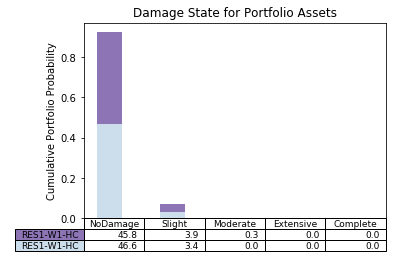

In [111]:
buttonReport = widgets.Button(description = "Generate Report")
def evaluate(buttonReport):
    global rows
    # Identify most recently modified dmg_by_asset file, and import it
    # Assumes realization 001 for NBCC2015.
    fileName = "dmg_by_asset-rlz-001_???.csv"
    file = sorted(glob.glob(fileName), key=os.path.getmtime, reverse=True)

    # Import it
    data = pd.read_csv(str(file[0]))

    # Find most likely damage state and emphasize it
    dmg = data.filter(['structural~no_damage_mean','structural~slight_mean','structural~moderate_mean','structural~extensive_mean','structural~complete_mean'], axis=1)
    dmg.columns = ['NoDamage','Slight','Moderate','Extensive','Complete']
    HighestProb = np.round(np.multiply(dmg.max(axis=1),100),0)
    MostLikelyState = dmg.idxmax(axis=1)
    data['MostLikelyState'] = MostLikelyState
    data["Probability [%]"] = HighestProb

    # Export table to csv 
    data.to_csv(r'PortfolioDamage.csv', index = False)

    # Plot Cumulative Portfolio State 

    # Based on https://matplotlib.org/3.2.1/gallery/misc/table_demo.html#sphx-glr-gallery-misc-table-demo-py
    dmgforplot = dmg.values/len(rows)
    columns = dmg.columns.tolist()
    rows = data['taxonomy'].tolist()
    values = np.arange(0, 1, 0.05)
    value_increment = 0.1
    colors = plt.cm.BuPu(np.linspace(0.2, 0.6, len(rows)))
    n_rows = len(dmgforplot)
    index = np.arange(len(columns)) + 0.3
    bar_width = 0.4
    y_offset = np.zeros(len(columns))

    # Plot bars and create text labels for the table
    cell_text = []
    for row in range(n_rows):
        plt.bar(index, dmgforplot[row], bar_width, bottom=y_offset, color=colors[row])
        y_offset = y_offset + (dmgforplot[row])
        cell_text.append(['%1.1f' % (x * 100.0) for x in dmgforplot[row]])
    # Reverse colors and text labels to display the last value at the top.
    colors = colors[::-1]
    cell_text.reverse()
    
    # Add a table at the bottom of the axes
    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          rowColours=colors,
                          colLabels=columns,
                          loc='bottom')
    
    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.2, bottom=0.2)
    
    plt.ylabel("Cumulative Portfolio Probability")
    plt.xticks([])
    plt.title('Damage State for Portfolio Assets')
    
    plt.show()


buttonReport.on_click(evaluate)
display(buttonReport)